# Real-time Load Forecasting and Resource Management - Advanced Modeling


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    tf_available = True
except ImportError:
    tf_available = False

plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## 1. Data loading and exploration

In [12]:
# Load the extended feature set data
data_path = '../processed_data/c7_user_DrrEIEW_timeseries.csv'

try:
    df = pd.read_csv(data_path)
    print(f"Successfully loaded data, shape: {df.shape}")
    
    # Display first few rows
    display(df.head())
    
    # View data types and basic information
    display(df.info())
    
    # View statistical summary of numerical features
    display(df.describe())
    
except Exception as e:
    print(f"Error reading data: {e}")

Successfully loaded data, shape: (24348, 5)


,user,time_dt,average_usage_cpu,average_usage_memory,hour
0,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 00:00:00.000000,0.006195,0.002872,1970-01-01 00:00:00
1,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 00:11:25.848387,0.005302,0.004875,1970-01-01 00:00:00
2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 00:12:01.145426,0.021851,0.012482,1970-01-01 00:00:00
3,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 00:17:52.299793,0.000381,0.005836,1970-01-01 00:00:00
4,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,1970-01-01 00:17:53.489241,0.018097,0.019287,1970-01-01 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24348 entries, 0 to 24347
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user                  24348 non-null  object 
 1   time_dt               24348 non-null  object 
 2   average_usage_cpu     24348 non-null  float64
 3   average_usage_memory  24348 non-null  float64
 4   hour                  24348 non-null  object 
dtypes: float64(2), object(3)
memory usage: 951.2+ KB


None

,average_usage_cpu,average_usage_memory
count,24348.000000,24348.000000
mean,0.008970,0.007235
std,0.013341,0.005893
min,0.000000,0.000000
25%,0.000611,0.003777
50%,0.002651,0.005287
75%,0.012466,0.010101
max,0.054626,0.022247


### 1.1 Check for missing values

In [13]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Percentage', ascending=False)

display(missing_df[missing_df['Missing Count'] > 0])

,Missing Count,Missing Percentage


### 1.2 Time feature inspection and transformation

In [14]:
# Check and transform time features
time_columns = [col for col in df.columns if 'time' in col.lower() and 'dt' not in col.lower()]
print(f"Time-related columns: {time_columns}")

for col in time_columns:
    if col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            df[f'{col}_dt'] = pd.to_datetime(df[col], unit='us')
            print(f"Converting column {col} to datetime format")

# Ensure time series index
if 'time_dt' in df.columns:
    # Set time column as index
    df_ts = df.set_index('time_dt').sort_index()
    print("Time column set as index and sorted")
    display(df_ts.head())
else:
    print("time_dt column not found, checking time column conversion")

Time-related columns: []
Time column set as index and sorted


,user,average_usage_cpu,average_usage_memory,hour
time_dt,,,,
1970-01-01 00:00:00.000000,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.006195,0.002872,1970-01-01 00:00:00
1970-01-01 00:11:25.848387,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.005302,0.004875,1970-01-01 00:00:00
1970-01-01 00:12:01.145426,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.021851,0.012482,1970-01-01 00:00:00
1970-01-01 00:17:52.299793,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.000381,0.005836,1970-01-01 00:00:00
1970-01-01 00:17:53.489241,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,0.018097,0.019287,1970-01-01 00:00:00


### 1.3 The distribution of the target variable and visualization of the time series

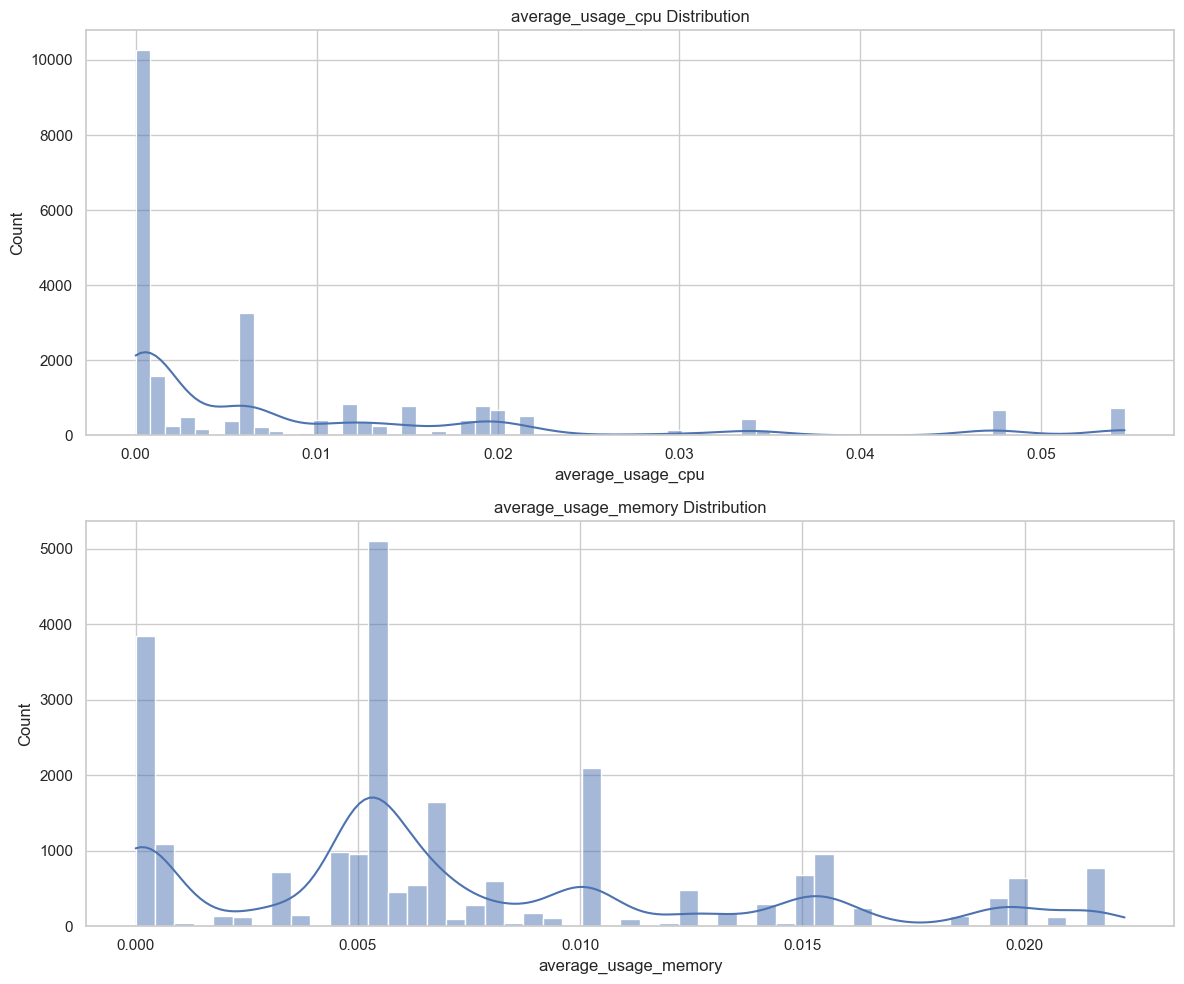

In [15]:
# Define target variables (CPU and memory usage)
target_vars = ['average_usage_cpu', 'average_usage_memory']

# Check if target variables exist
target_vars = [var for var in target_vars if var in df.columns]

if target_vars:
    # Visualize target variable distributions
    fig, axes = plt.subplots(len(target_vars), 1, figsize=(12, 5*len(target_vars)))
    if len(target_vars) == 1:
        axes = [axes]
        
    for i, var in enumerate(target_vars):
        # Histogram
        sns.histplot(df[var], ax=axes[i], kde=True)
        axes[i].set_title(f'{var} Distribution')
        axes[i].set_xlabel(var)
    
    plt.tight_layout()
    plt.show()
    
    # Time series visualization
    #if 'time_dt' in df.columns:
    #    fig, axes = plt.subplots(len(target_vars), 1, figsize=(16, 6*len(target_vars)))
    #    if len(target_vars) == 1:
    #        axes = [axes]
            
    #    for i, var in enumerate(target_vars):
    #        axes[i].plot(df['time_dt'], df[var])
    #        axes[i].set_title(f'{var} Time Series')
    #        axes[i].set_xlabel('Time')
    #        axes[i].set_ylabel(var)
        
    #    plt.tight_layout()
    #    plt.show()
else:
    print("Target variables not found in dataset, please check column names")

## 2. Feature engineering

Based on the previous model results and data analysis, we will create more advanced features to enhance the model performance.

### 2.1 Creation of temporal characteristics

In [16]:
# Create time features
def create_time_features(df, time_col='time_dt'):
    """Create rich time features from time column"""
    print("\nCreating time features...")
    
    # Ensure column exists
    if time_col not in df.columns:
        print(f"Column {time_col} does not exist")
        return df
    
    # Copy dataframe to avoid modifying original data
    df_new = df.copy()
    
    # Ensure time column is datetime type
    df_new[time_col] = pd.to_datetime(df_new[time_col])
    print(f"Converting {time_col} to datetime type")
    
    # Create features from datetime
    df_new['hour_of_day'] = df_new[time_col].dt.hour
    df_new['day_of_week'] = df_new[time_col].dt.dayofweek
    df_new['day_of_month'] = df_new[time_col].dt.day
    df_new['month'] = df_new[time_col].dt.month
    
    # Create weekend indicator (0=weekday, 1=weekend)
    df_new['is_weekend'] = df_new['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create time of day classification
    def get_day_part(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 22:
            return 'evening'
        else:
            return 'night'
    
    df_new['day_part'] = df_new['hour_of_day'].apply(get_day_part)
    
    # One-hot encode time periods
    df_new = pd.get_dummies(df_new, columns=['day_part'], prefix='day_part')
    
    # Create cyclical features for hour and date (sine and cosine transformations)
    df_new['hour_sin'] = np.sin(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['hour_cos'] = np.cos(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['day_sin'] = np.sin(2 * np.pi * df_new['day_of_week'] / 7)
    df_new['day_cos'] = np.cos(2 * np.pi * df_new['day_of_week'] / 7)
    
    return df_new

# Apply time feature creation function
if 'time_dt' in df.columns:
    df = create_time_features(df)
    print("Time features created")
    
    # Display newly created time feature columns
    time_feature_cols = ['hour_of_day', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos']
    time_feature_cols = [col for col in time_feature_cols if col in df.columns]
    
    if time_feature_cols:
        display(df[time_feature_cols].head())
else:
    print("Cannot create time features, missing time_dt column")


Creating time features...
Converting time_dt to datetime type
Time features created


,hour_of_day,day_of_week,is_weekend,hour_sin,hour_cos
0,0,3,0,0.0,1.0
1,0,3,0,0.0,1.0
2,0,3,0,0.0,1.0
3,0,3,0,0.0,1.0
4,0,3,0,0.0,1.0


### 2.2 Sliding window feature (lag feature)

In [17]:
# Create lag features (based on sorted time series)
def create_lag_features(df, target_cols, lag_periods=[1, 3, 6, 12, 24], sort_col='time_dt'):
    """Create lag features for target columns"""
    # Ensure data is sorted by time
    df_sorted = df.sort_values(by=sort_col).copy()
    
    # Create features for each target column and lag period
    for target in target_cols:
        for lag in lag_periods:
            # Create lag feature
            df_sorted[f'{target}_lag_{lag}'] = df_sorted[target].shift(lag)
    
    return df_sorted

# Create rolling window statistical features
def create_rolling_features(df, target_cols, windows=[3, 6, 12, 24], sort_col='time_dt'):
    """Create rolling window statistical features for target columns"""
    # Ensure data is sorted by time
    df_sorted = df.sort_values(by=sort_col).copy()
    
    # Create features for each target column and window
    for target in target_cols:
        for window in windows:
            # Create rolling mean
            df_sorted[f'{target}_rolling_mean_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).mean()
            # Create rolling standard deviation
            df_sorted[f'{target}_rolling_std_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).std()
            # Create rolling min and max
            df_sorted[f'{target}_rolling_min_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).min()
            df_sorted[f'{target}_rolling_max_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).max()
    
    return df_sorted

# Apply lag and rolling window feature creation
if 'time_dt' in df.columns and target_vars:
    # Create lag features
    df = create_lag_features(df, target_vars)
    print("Lag features created")
    
    # Create rolling window features
    df = create_rolling_features(df, target_vars)
    print("Rolling window features created")
    
    # Display first few rows of new features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col][:5]
    if lag_cols:
        display(df[lag_cols].head(10))
else:
    print("Cannot create time series features, missing required columns")

Lag features created
Rolling window features created


,average_usage_cpu_lag_1,average_usage_cpu_lag_3,average_usage_cpu_lag_6,average_usage_cpu_lag_12,average_usage_cpu_lag_24
0,NaN,NaN,NaN,NaN,NaN
1,0.006195,NaN,NaN,NaN,NaN
2,0.005302,NaN,NaN,NaN,NaN
3,0.021851,0.006195,NaN,NaN,NaN
4,0.000381,0.005302,NaN,NaN,NaN
5,0.018097,0.021851,NaN,NaN,NaN
6,0.054626,0.000381,0.006195,NaN,NaN
7,0.054626,0.018097,0.005302,NaN,NaN
8,0.000381,0.054626,0.021851,NaN,NaN
9,0.021851,0.054626,0.000381,NaN,NaN


## 3. Prepare model training data

In [18]:
def prepare_data_for_modeling(df, target_vars):
    """Prepare data for model training"""
    print("\nPreparing data for model training...")
    
    # Handle missing values
    print("Handling missing values...")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['int64', 'float64']:
                # Fill numeric columns with median
                df[col] = df[col].fillna(df[col].median())
            else:
                # Fill non-numeric columns with mode
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # Remove unnecessary columns
    cols_to_drop = []
    
    # Remove high-cardinality ID columns
    id_cols = [col for col in df.columns if 'id' in col.lower() or 'name' in col.lower() or 'user' in col.lower()]
    cols_to_drop.extend(id_cols)
    
    # Remove original timestamp columns (keep converted dt columns)
    timestamp_cols = [col for col in df.columns if ('time' in col.lower() and 'dt' not in col.lower())]
    cols_to_drop.extend(timestamp_cols)
    
    # Exclude target variables
    cols_to_drop = [col for col in cols_to_drop if col not in target_vars]
    
    # Remove columns that are all NaN
    null_cols = df.columns[df.isnull().all()].tolist()
    cols_to_drop.extend(null_cols)
    
    # Drop columns
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')
    print(f"Dropped {len(cols_to_drop)} columns")
    
    # Convert categorical variables to numeric
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        if col not in target_vars:  # Don't transform target variables
            # Label encode categorical variables
            df[col] = pd.factorize(df[col])[0]
    
    print("Data preparation completed")
    return df

df = prepare_data_for_modeling(df, target_vars)


Preparing data for model training...
Handling missing values...
Dropped 1 columns
Data preparation completed


### 4. Build a model for each target variable

In [19]:
rf_cpu = None
scaler_cpu = None

rf_memory = None
scaler_memory = None

def visualize_predictions_separate(y_true, predictions_dict, title_prefix="Prediction Comparison"):
    """Create a separate prediction vs true value comparison chart for each model"""

    # First, create an overview chart containing all models
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_true)), y_true, 'k-', label='True Value')

    for model_name, preds in predictions_dict.items():
        plt.plot(range(len(preds)), preds, '--', label=f'{model_name} Prediction')

    plt.title(f"{title_prefix} - Overview")
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f"{title_prefix.replace(' ', '_')}_overview.png")
    plt.show()

    # Then, create a separate chart for each model
    for model_name, preds in predictions_dict.items():
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(y_true)), y_true, 'k-', label='True Value')
        plt.plot(range(len(preds)), preds, 'r--', label=f'{model_name} Prediction')

        plt.title(f"{title_prefix} - {model_name}")
        plt.xlabel('Time')
        plt.ylabel('Target Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        #plt.savefig(f"{title_prefix.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
        plt.show()

    print(f"Created {len(predictions_dict) + 1} prediction comparison charts")

def evaluate_models(df, target_var, test_size=0.2, random_state=42):
    """Build and evaluate multiple prediction models"""
    print(f"\nEvaluating prediction models for {target_var}...")
    global rf_cpu, scaler_cpu, rf_memory, scaler_memory
    # Prepare features and target
    y = df[target_var]
    X = df.drop(columns=[col for col in df.columns if col in [target_var] or col.startswith('time_')])

    print(f"Feature count: {X.shape[1]}")
    print(f"Sample count: {X.shape[0]}")

    # Create training and testing sets (time series split)
    # To ensure we don't use future data to predict the past, use the last test_size proportion of data as the test set
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    # Feature standardization
    scaler = StandardScaler()
    # Assign the scaler for joblib to save
    if target_var == 'average_usage_cpu':
        scaler_cpu = scaler
    elif target_var == 'average_usage_memory':
        scaler_memory = scaler

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model result storage
    model_results = []

    # Random forest
    print("\nTraining Random Forest...")
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
    # Assign the model for joblib to save
    if target_var == 'average_usage_cpu':
        rf_cpu = rf
    elif target_var == 'average_usage_memory':
        rf_memory = rf
    rf.fit(X_train_scaled, y_train)

    # Predict
    rf_preds = rf.predict(X_test_scaled)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
    mae = mean_absolute_error(y_test, rf_preds)
    r2 = r2_score(y_test, rf_preds)

    print(f"Random Forest - RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")
    model_results.append({"model": "Random Forest", "rmse": rmse, "mae": mae, "r2": r2})

    # Summarize results
    results_df = pd.DataFrame(model_results)
    results_df = results_df.sort_values('rmse')

    print("\nModel performance summary:")
    print(results_df)

    # Visualize prediction results
    # Collect prediction results for visualization
    predictions_dict = {}
    if 'rf_preds' in locals():
        predictions_dict['Random Forest'] = rf_preds

    visualize_predictions_separate(
        y_true=y_test,
        predictions_dict=predictions_dict,
        title_prefix=f"{target_var} Prediction Comparison"
    )

    # Return the best model and evaluation results
    return results_df


Evaluating prediction models for average_usage_cpu...
Feature count: 36
Sample count: 24348
Training set shape: (19478, 36), Test set shape: (4870, 36)

Training Random Forest...
Random Forest - RMSE: 0.002500, MAE: 0.000894, R²: 0.971057

Model performance summary:
           model    rmse       mae        r2
0  Random Forest  0.0025  0.000894  0.971057


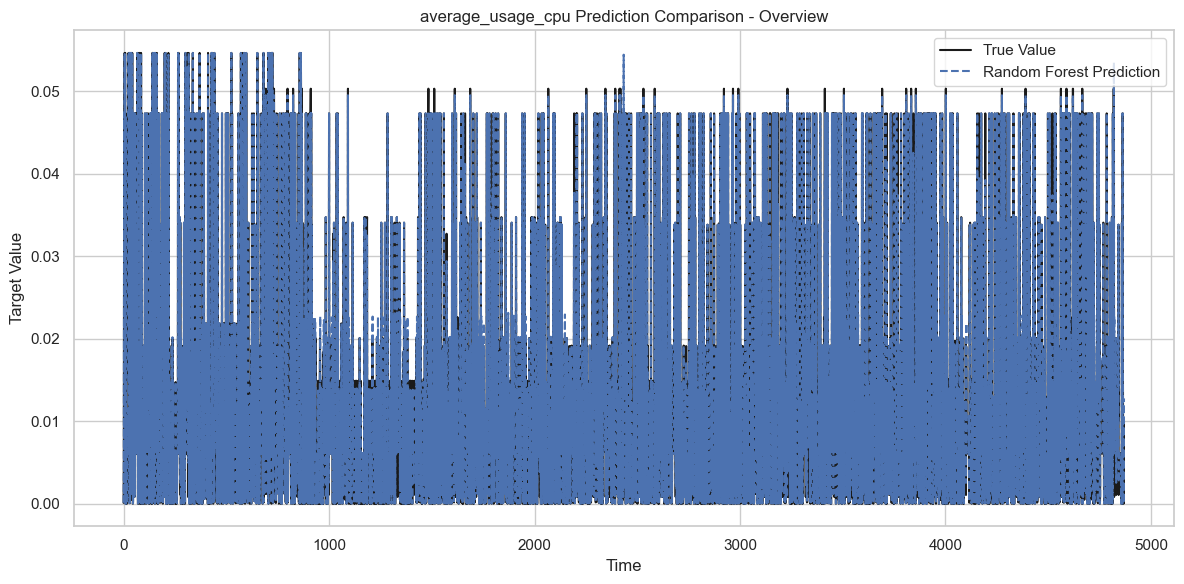

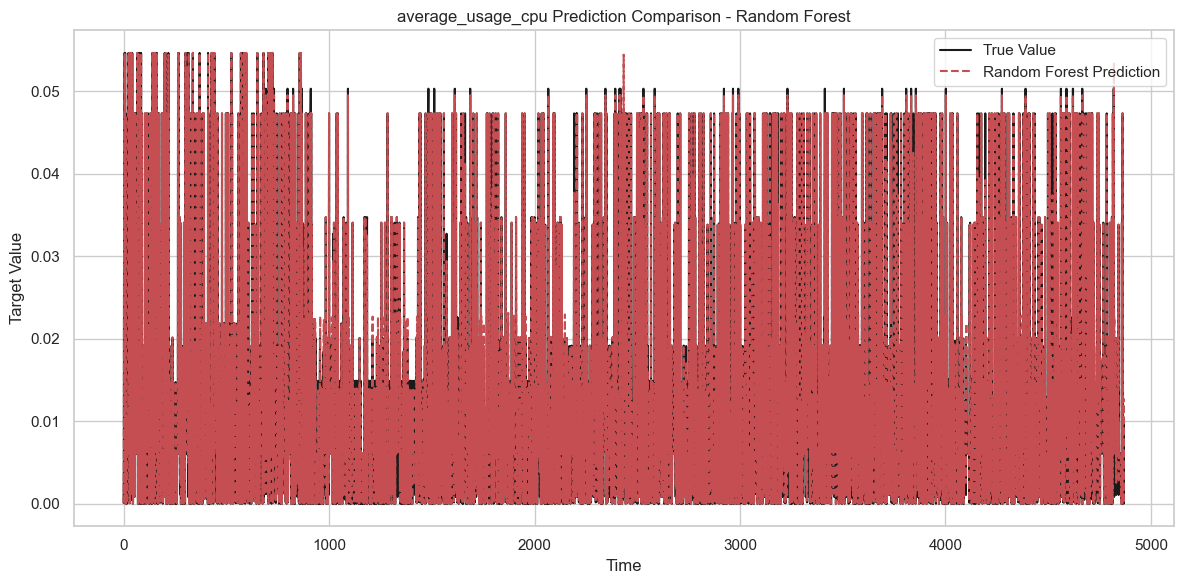

Created 2 prediction comparison charts

Evaluating prediction models for average_usage_memory...
Feature count: 36
Sample count: 24348
Training set shape: (19478, 36), Test set shape: (4870, 36)

Training Random Forest...
Random Forest - RMSE: 0.001508, MAE: 0.000469, R²: 0.940543

Model performance summary:
           model      rmse       mae        r2
0  Random Forest  0.001508  0.000469  0.940543


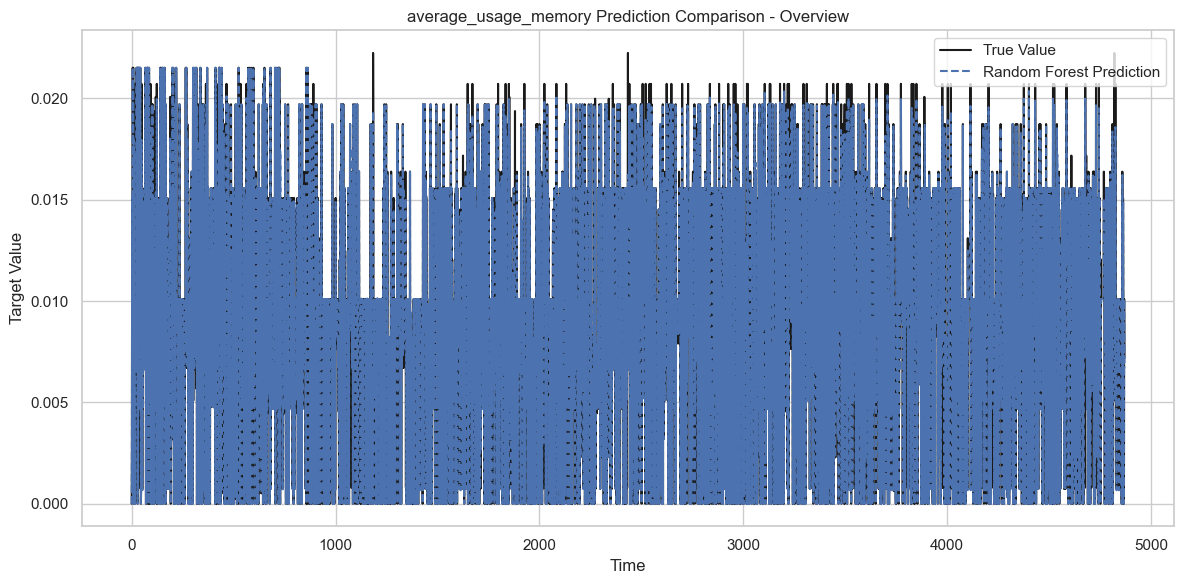

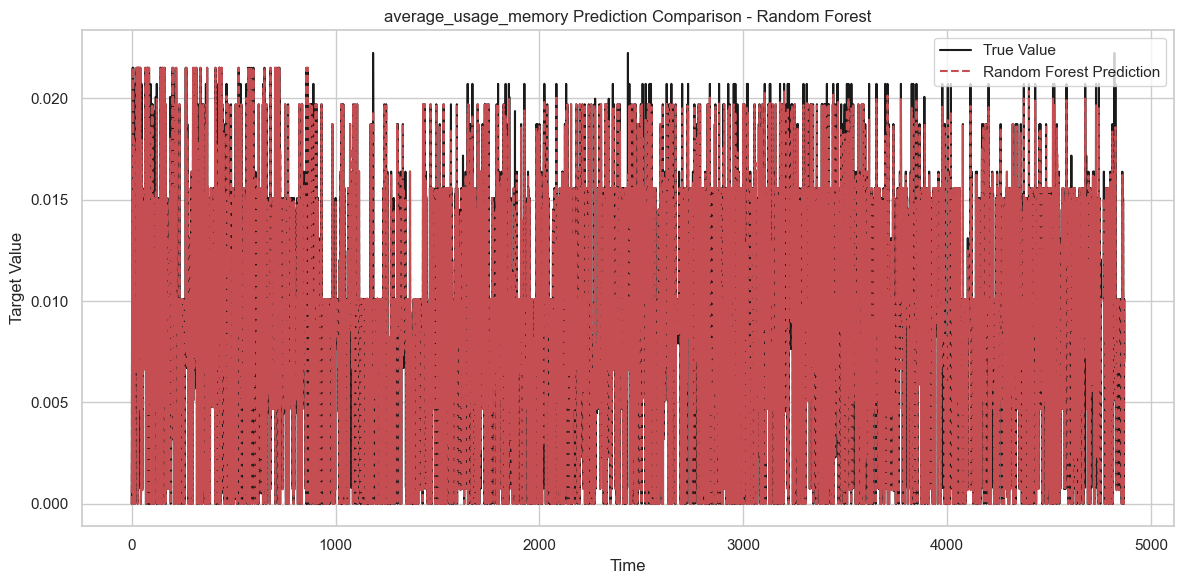

Created 2 prediction comparison charts
Modeling completed!


In [20]:
for target_var in target_vars:
    # Filter out rows containing NaN values
    df_clean = df.dropna(subset=[target_var])

    # Filter out lag features of other target variables
    other_targets = [t for t in target_vars if t != target_var]
    cols_to_drop = []
    for other_target in other_targets:
        cols_to_drop.extend([col for col in df_clean.columns if col.startswith(f"{other_target}_lag_")])
        cols_to_drop.extend([col for col in df_clean.columns if col.startswith(f"{other_target}_rolling_")])

    df_model = df_clean.drop(columns=cols_to_drop, errors='ignore')
    # Build and evaluate model
    results_df = evaluate_models(df_model, target_var)
    #results_df.to_csv(f"model_results_{target_var}.csv", index=False)
print("Modeling completed!")

In [21]:
import joblib

joblib.dump(rf_cpu, '../models/rf_cpu_model.pkl')
joblib.dump(scaler_cpu, '../models/rf_cpu_scaler.pkl')

joblib.dump(rf_memory, '../models/rf_memory_model.pkl')
joblib.dump(scaler_memory, '../models/rf_memory_scaler.pkl')


['../models/rf_memory_scaler.pkl']